In [1]:
import glob
from datetime import datetime
import logging as log
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from sklearn.externals import joblib
import gzip
from multiprocessing import Pool

%matplotlib notebook

In [2]:
class ModelSimilarity:

    # Uses a model (e.g. Word2Vec model) to calculate the similarity between two terms.
    
    def __init__(self, model):
        self.model = model

    def similarity(self, ranking_i, ranking_j):
        sim = 0.0
        pairs = 0
        for term_i in ranking_i:
            for term_j in ranking_j:
                try:
                    sim += self.model.similarity(term_i, term_j)
                    pairs += 1
                except:
                    # print "Failed pair (%s,%s)" % (term_i,term_j)
                    pass
        if pairs == 0:
            return 0.0
        return sim / pairs

In [3]:
class WithinTopicMeasure:
 
    # Measures within-topic coherence for a topic model, based on a set of term rankings.

    def __init__(self, metric):
        self.metric = metric

    def evaluate_ranking(self, term_ranking):
        return self.metric.similarity(term_ranking, term_ranking)

    def evaluate_rankings(self, term_rankings):
        scores = []
        overall = 0.0
        for topic_index in range(len(term_rankings)):
            score = self.evaluate_ranking(term_rankings[topic_index])
            scores.append(score)
            overall += score
        overall /= len(term_rankings)
        return overall

In [4]:
# To get the topic words from the model
def get_topics(ldamodel, num_topics, num_words):
    topics = []
    for topic_id, topic in ldamodel.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        topic = [word for word, _ in topic]
        topics.append(topic)
    return topics

# ldamodel = joblib.load('data/eos/lda/28_LDAmodel_EOS.pkl') 
# print(ldamodel)
# print(get_topics(ldamodel, 28, 10))

In [17]:
%%time


from topic_coherence import ModelSimilarity, WithinTopicMeasure
    

def execute_coherence(topic_model_path):
    model_list = glob.glob(topic_model_path)
    model_list.sort()
  
    model_path = 'data/eos/word2vec_model_all.model'
    log.info("Loading Word2Vec model from %s ..." % model_path)
    model = gensim.models.Word2Vec.load(model_path)
    
    metric = ModelSimilarity(model)
    validation_measure = WithinTopicMeasure(metric)

    coherence_list = []
    
    for fname in model_list:
        ldamodel = joblib.load(fname)
        topic_num = int(fname[13:15])
        truncated_term_rankings = get_topics(ldamodel, topic_num, 100)
        coherence_scores = validation_measure.evaluate_rankings(truncated_term_rankings)
        log.info("Model coherence (k=%d) = %.4f" % (topic_num, coherence_scores))
        print(coherence_scores)
        coherence_list.append([topic_num, coherence_scores])
        
    print(coherence_list)
    coherence_list.sort(key=lambda x: x[0])
    
        
    # Show graph
    indices = [x[0] for x in coherence_list]
    y = [abs(x[1]) for x in coherence_list]
    n = len(coherence_list)
    x = range(n)
    plt.bar(x, y, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.show()
    plt.savefig('data/eos/graphs/%s_tc_w2v_coherence.png' % topic_model_path[15:-4], dpi=800)




CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.4 µs


0.302125632268
0.296807179204
0.295300414438
0.292190169547
0.291433224846
0.291872095817
0.291393655236
0.290535630856
0.29023396073
0.290444481123
0.289389022501
[[10, 0.3021256322675151], [12, 0.29680717920442734], [14, 0.29530041443752675], [16, 0.29219016954702559], [18, 0.2914332248462555], [20, 0.29187209581710166], [22, 0.29139365523635097], [24, 0.29053563085563006], [26, 0.29023396072967345], [28, 0.2904444811230914], [30, 0.28938902250132936]]


<IPython.core.display.Javascript object>


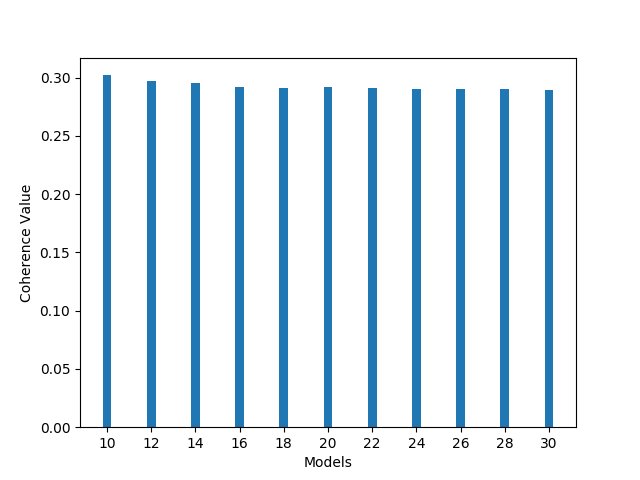

In [19]:
# topic_model_path = 'data/eos/lda/*_LDAmodel_EOS.pkl'
topic_model_path = 'data/eos/lda/*_LSImodel_EOS.pkl'
# topic_model_path = 'data/eos/lda/*_Malletmodel_EOS.pkl'
execute_coherence(topic_model_path)